# Calculating rise/set times with astropy

In [29]:
%matplotlib inline
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import numpy as np
import matplotlib.pyplot as plt
import datetime
import astropy.units as u
from astropy.coordinates import EarthLocation, Latitude, \
                                Longitude, get_sun
from astropy.time import Time
from astropy.coordinates import AltAz

##################################################
# IERS table patch from @eteq ####################
from astropy.utils.data import download_file
from astropy.utils import iers
iers.IERS.iers_table = iers.IERS_A.open(download_file(iers.IERS_A_URL, 
                                                      cache=True))
##################################################

# Some convenience functions

def get_altitude(target, time, location, kwargs={}):
    '''
    Compute altitude of a `target` at a particular time, given
     an observer's `location` (EarthLocation).
    '''
    altaz = target.transform_to(AltAz(target.ra, target.dec, 
                                location=location, obstime=time,
                                **kwargs))
    return altaz.alt

def timebracket(t0, dt, N):
    '''
    Generate `N` times bracketing `t0` going
    backwards and forwards `dt` hours
    
    t0 : datetime.datetime
        Initial time
    dt : float
        Number of hours before and after t0
    N : int
        Number of datetimes in range
    '''
    previous_dt = t0 + np.linspace(-dt, 0, N)*u.hour
    next_dt = t0 + np.linspace(0, dt, N)*u.hour
    return previous_dt, next_dt

def timelinspace(t0, dt, N):
    '''
    Generate `N` linearly spaced times between `t0` 
    and t0+dt where [dt] = day
    
    t0 : datetime.datetime
        Initial time
    dt : float
        Number of days before/after t0. 
        dt < 0 = before, dt > 0 = after
    N : int
        Number of times to generate in range
    '''
    # Keep array in time order
    if dt > 0:
        time_array = t0 + np.linspace(0, dt, N)*u.day
    elif dt < 0:
        time_array = t0 + np.linspace(dt, 0, N)*u.day
    return time_array

def horiz_cross_rising(t, a, horizon=0, unit=u.degree, return_bounds=False):
    '''
    Find time `t` when values in array `a` go from
    negative to positive (exclude endpoints)
    
    `return_nearest` will return nearest times to zero-crossing
    '''
    condition = (a[:-1] < horizon*unit) * (a[1:] > horizon*unit)
    if sum(condition) < 1:
        return []

    if return_bounds:
        nearest_index = np.argwhere(condition)[0][0]
        
        if a[nearest_index] > horizon*unit:
            lower_bound, upper_bound = t[nearest_index-1], t[nearest_index]
        else:
            lower_bound, upper_bound = t[nearest_index], t[nearest_index+1]
        return lower_bound, upper_bound
    
    return t[condition][0]

def horiz_cross_setting(t, a, horizon=0, unit=u.degree, return_bounds=False):
    '''
    Find time `t` when values in array `a` go from
    positive to negative (exclude endpoints)
    '''
    condition = (a[:-1] > horizon*unit) * (a[1:] < horizon*unit)
    if sum(condition) < 1:
        return []

    if return_bounds:
        nearest_index = np.argwhere(condition)[0][0]
        
        if a[nearest_index] < horizon*unit:
            lower_bound, upper_bound = t[nearest_index-1], t[nearest_index]
        else:
            lower_bound, upper_bound = t[nearest_index], t[nearest_index+1]
        return lower_bound, upper_bound
    
    return t[condition][0]

def get_rise(time, dt, location, N=1000, return_bounds=False):
    times = timelinspace(time, dt, N)
    sun = get_sun(next_times)
    altitudes = get_altitude(sun, times, location)
    return horiz_cross_rising(times, altitudes, 
                              return_bounds=return_bounds)

def sunrise(time, location, which='nearest', N=1000):
    if which == 'nearest' or which == 'next':
        # Calculate next sunrise

        # Do a coarse search with error O(~minute), 
        # return upper/lower bounds
        rise_bounds = get_rise(time, 1, location, N=N, 
                               return_bounds=True)
        
        # Do a fine search with error O(~0.1*second),
        # return the nearest time to sunrise
        next_rise = get_rise(rise_bounds[0], 
                             (rise_bounds[1] - rise_bounds[0]).value, 
                             location, N=N)
        if which == 'next':
            return next_rise

    if which == 'nearest' or which == 'previous':
        
        # Calculate previous sunrise

        # Do a coarse search with error O(~minute), 
        # return upper/lower bounds
        rise_bounds = get_rise(time, -1, location, N=N, 
                               return_bounds=True)
        
        # Do a fine search with error O(~0.1*second),
        # return the nearest time to sunrise
        previous_rise = get_rise(rise_bounds[0], 
                                 (rise_bounds[1] - rise_bounds[0]).value, 
                                 location, N=N)
        if which == 'previous':
            return previous_rise
    
    if which == 'nearest':
        if abs(previous_rise - time) < abs(next_rise - time):
            return previous_rise
        else: 
            return next_rise
    raise ValueError, "which can be: 'next', 'previous', 'nearest'"

# Input observer location at Subaru
latitude = '19:49:42.600'
longitude = '-155:28:48.900'
elevation = 0*u.m
location = EarthLocation(lat=latitude, lon=longitude,
                         height=elevation)

time = Time('2015-05-29', 
            location=location, scale='utc')
nearest_sunrise = sunrise(time, location, which='nearest')
next_sunrise = sunrise(time, location, which='next')
previous_sunrise = sunrise(time, location, which='previous')
print(nearest_sunrise)

2015-05-28 15:47:18.244
0.342149957766
0.657719781844


### Compare to PyEphem

In [17]:
import ephem
sun = ephem.Sun()
obs = ephem.Observer()
obs.lat = latitude
obs.lon = longitude
obs.date = time.datetime
obs.pressure = 1e3 # Turn on/off pressure/refraction
sun.compute(obs)
print("previous sunrise:", obs.previous_rising(sun, use_center=True))
print("previous sunset:", obs.previous_setting(sun, use_center=True))
print("next sunrise:", obs.next_rising(sun, use_center=True))
print("next sunset:", obs.next_setting(sun, use_center=True))

previous sunrise: 2015/5/28 15:44:00
previous sunset: 2015/5/28 04:54:10
next sunrise: 2015/5/29 15:43:52
next sunset: 2015/5/29 04:54:34


### Results

The $N$ parameter in `timebracket()` controls the density of time points tested for rise/set, and should therefore control the precision of the rise/set times. 

I'm unsure how PyEphem handles precession/nutation, which [Brandon Rhodes says uses IAU 1980 conventions](https://twitter.com/brandon_rhodes/status/605044030406303744), so I'm unsure how close the numbers should be. 

Also note: I'm calculating for an atmosphere *with refraction*, and these calculations are for sunrise/sunset as defined by when the solar centroid crosses the horizon, not the crossing of the nearest limb. This may account for part of the the differences from the [USNO](http://aa.usno.navy.mil/data/docs/RS_OneDay.php).

| Event | astropy $N = 1000$| astropy $N=3000$ | PyEphem | USNO |
|-------|-------------------|------------------|---------|------|
|previous sunrise| 15:45:35 | 15:45:54 | 15:44:00 | [15:43](http://aa.usno.navy.mil/rstt/onedaytable?form=2&ID=AA&year=2015&month=5&day=28&place=Subaru&lon_sign=-1&lon_deg=155&lon_min=29&lat_sign=1&lat_deg=19&lat_min=50&tz=&tz_sign=-1) |
|previous sunset| 04:52:15 | 04:53:01 | 04:54:10 | [04:55](http://aa.usno.navy.mil/rstt/onedaytable?form=2&ID=AA&year=2015&month=5&day=28&place=Subaru&lon_sign=-1&lon_deg=155&lon_min=29&lat_sign=1&lat_deg=19&lat_min=50&tz=&tz_sign=-1) |
|next sunrise| 15:46:09 | 15:46:59 | 15:43:52 | [15:43](http://aa.usno.navy.mil/rstt/onedaytable?form=2&ID=AA&year=2015&month=5&day=29&place=Subaru&lon_sign=-1&lon_deg=155&lon_min=29&lat_sign=1&lat_deg=19&lat_min=50&tz=&tz_sign=-1) |
|next sunset| 04:52:49 | 04:52:37 | 04:54:34 | [04:56](http://aa.usno.navy.mil/rstt/onedaytable?form=2&ID=AA&year=2015&month=5&day=29&place=Subaru&lon_sign=-1&lon_deg=155&lon_min=29&lat_sign=1&lat_deg=19&lat_min=50&tz=&tz_sign=-1) |

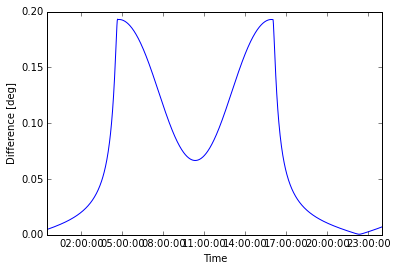

In [132]:
# Compare with vs without atmosphere: 

previous_alt_sun_noatm = get_altitude(previous_sun, previous_times, location)
plt.plot_date(previous_times.plot_date, 
             (previous_alt_sun-previous_alt_sun_noatm).to('degree'), '-')
ax = plt.gca()
ax.set(xlabel='Time', ylabel='Difference [deg]')
plt.show()